# Pytorch Cityscape Segmentation

## Setup Paths and Configs

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/Pytorch Cityscape Image Segmentation'

/content/drive/MyDrive/Pytorch Cityscape Image Segmentation


In [ ]:
PROJECT_DIR = '/content/drive/MyDrive/Pytorch Cityscape Image Segmentation'

TRAIN_IMG_DIR = os.path.join(PROJECT_DIR, 'Dataset/images_prepped_train')
TRAIN_MASK_DIR = os.path.join(PROJECT_DIR, 'Dataset/annotations_prepped_train')
TEST_IMG_DIR = os.path.join(PROJECT_DIR, 'Dataset/images_prepped_test')
TEST_MASK_DIR = os.path.join(PROJECT_DIR, 'Dataset/annotations_prepped_test')

In [ ]:
import torch

LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 100
NUM_WORKERS = 2
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
NUM_CLASSES = 12

## Data Preparation

### Dataset

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [ ]:
class CityScapeDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index])
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

### Transforms

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
transforms = A.Compose([
    A.Resize(IMAGE_HEIGHT, IMAGE_WIDTH),
    A.Normalize(),
    ToTensorV2()
])

### DataLoader

In [ ]:
train_ds = CityScapeDataset(
    image_dir=TRAIN_IMG_DIR,
    mask_dir=TRAIN_MASK_DIR,
    transform=transforms,
)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
)

val_ds = CityScapeDataset(
    image_dir=TEST_IMG_DIR,
    mask_dir=TEST_MASK_DIR,
    transform=transforms,
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False,
)

## Build Model Architecture

In [ ]:
import torch.nn as nn
import torchvision.transforms.functional as TF

### Double-Conv

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

### U-NET

In [ ]:
class UNET(nn.Module):
    def __init__(
            self, in_channels, out_channels, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [ ]:
input = torch.randn((1, 3, IMAGE_HEIGHT, IMAGE_WIDTH)) # BCHW
model = UNET(in_channels=3, out_channels=NUM_CLASSES)
output = model(input)
print(input.shape)
print(output.shape)

torch.Size([1, 3, 256, 256])
torch.Size([1, 12, 256, 256])


### FCN8s

In [ ]:
class FCN8s(nn.Module):
  def __init__(self, in_channels, out_channels, features= [64, 128, 256, 512, 1024]):
    super().__init__()
    self.layers = nn.ModuleList()
    self.pool = nn.MaxPool2d(2, 2)

    for feature in features:
      self.layers.append(DoubleConv(in_channels, feature))
      in_channels = feature

    self.ups1 = nn.ConvTranspose2d(features[-1], features[-2], kernel_size=2, stride=2)
    self.ups2 = nn.ConvTranspose2d(features[-1], features[-3], kernel_size=2, stride=2)

    self.predictions = nn.ConvTranspose2d(features[-2], out_channels, kernel_size=8, stride=8)

  def forward(self, x):
    skip_connections=[]

    for idx,layer in enumerate(self.layers):
      x = layer(x)
      x = self.pool(x)
      if idx in [2,3]:
        skip_connections.append(x)


    ups1 = self.ups1(x)
    concat1 = torch.concat([ups1, skip_connections[-1]], dim=1)

    ups2 = self.ups2(concat1)
    concat2 = torch.concat([ups2, skip_connections[-2]], dim=1)

    return self.predictions(concat2)

## Training Model

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.8/728.8 kB 29.0 MB/s eta 0:00:00


In [ ]:
from tqdm import tqdm
from torchmetrics import JaccardIndex
from torchmetrics.classification import Dice

### Configure Hyperparams

In [ ]:
model = FCN8s(in_channels=3, out_channels=NUM_CLASSES).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

IOU = JaccardIndex(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)
DICE = Dice(average='micro').to(DEVICE)

### Code Train and Evaluation Engine

In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device):
  model.train()
  total_loss = 0
  print('____Training_____')
  loop = tqdm(train_loader)
  for data in loop:
    images, labels = data[0].to(device), data[1].to(device, dtype=torch.int64)
    with torch.cuda.amp.autocast():
      preds = model(images)
      loss = criterion(preds, labels)

    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    total_loss += loss.item()
    loop.set_postfix(loss=loss.item())

  return total_loss / len(train_loader)

def evaluate(model, val_loader, criterion, device):
  model.eval()
  total_loss = 0
  total_iou = 0
  total_dice = 0
  print('____Evaluating_____')
  loop = tqdm(val_loader)
  for data in loop:
    images, labels = data[0].to(device), data[1].to(device, dtype=torch.int64)
    with torch.no_grad():
      preds = model(images)
      loss = criterion(preds, labels)
      iou_score = IOU(preds, labels)
      dice_score = DICE(preds, labels)

    total_loss += loss.item()
    total_iou += iou_score.item()
    total_dice += dice_score.item()
    loop.set_postfix(loss=loss.item())

  return (total_loss / len(val_loader),
          1 - (total_iou / len(val_loader)),
          1 - (total_dice / len(val_loader)),)

### Train and Plot Learning Curve

In [ ]:
metrics = {
    'train_loss': [],
    'val_loss': [],
    'iou_loss': [],
    'dice_loss': [],
}

for epoch in range(NUM_EPOCHS):
  print(f"[INFO]: Epoch {epoch + 1} of {NUM_EPOCHS}")
  train_loss = train_one_epoch(model, train_loader, criterion, optimizer, scaler, DEVICE)
  print(f'Mean Training Loss: {train_loss}')
  val_loss, iou_loss, dice_loss = evaluate(model, val_loader, criterion, DEVICE)
  print(f'Mean Validation Loss: {val_loss}')
  print(f'Mean IOU Loss: {iou_loss}')
  print(f'Mean Dice Loss: {dice_loss}')

  metrics['train_loss'].append(train_loss)
  metrics['val_loss'].append(val_loss)
  metrics['iou_loss'].append(iou_loss)
  metrics['dice_loss'].append(dice_loss)

print('TRAINING FINISHED!')

[INFO]: Epoch 1 of 100
____Training_____


100%|██████████| 23/23 [02:45<00:00,  7.22s/it, loss=1.37]


Mean Training Loss: 1.874558334765227
____Evaluating_____


100%|██████████| 7/7 [01:20<00:00, 11.49s/it, loss=2.8]


Mean Validation Loss: 2.7256453718457903
Mean IOU Loss: 0.9265967373337064
Mean Dice Loss: 0.6570547648838588
[INFO]: Epoch 2 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  4.21it/s, loss=0.875]


Mean Training Loss: 1.025365166042162
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.24it/s, loss=1.1]


Mean Validation Loss: 1.102653639657157
Mean IOU Loss: 0.8312492264168603
Mean Dice Loss: 0.38064852782658165
[INFO]: Epoch 3 of 100
____Training_____


100%|██████████| 23/23 [00:07<00:00,  3.26it/s, loss=0.767]


Mean Training Loss: 0.807808272216631
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  3.99it/s, loss=0.869]


Mean Validation Loss: 0.8636678372110639
Mean IOU Loss: 0.7294647012438094
Mean Dice Loss: 0.2459273764065334
[INFO]: Epoch 4 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  4.28it/s, loss=0.677]


Mean Training Loss: 0.7102771945621656
____Evaluating_____


100%|██████████| 7/7 [00:02<00:00,  2.94it/s, loss=0.855]


Mean Validation Loss: 0.8352904149464199
Mean IOU Loss: 0.7350416609219143
Mean Dice Loss: 0.27339842489787514
[INFO]: Epoch 5 of 100
____Training_____


100%|██████████| 23/23 [00:06<00:00,  3.63it/s, loss=0.573]


Mean Training Loss: 0.6389992133430813
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.21it/s, loss=0.677]


Mean Validation Loss: 0.6985360043389457
Mean IOU Loss: 0.6858500582831246
Mean Dice Loss: 0.20709092276436947
[INFO]: Epoch 6 of 100
____Training_____


100%|██████████| 23/23 [00:06<00:00,  3.82it/s, loss=0.554]


Mean Training Loss: 0.5763329837633215
____Evaluating_____


100%|██████████| 7/7 [00:02<00:00,  2.61it/s, loss=0.682]


Mean Validation Loss: 0.6945105280194964
Mean IOU Loss: 0.6613659730979374
Mean Dice Loss: 0.19660884141921997
[INFO]: Epoch 7 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  4.22it/s, loss=0.491]


Mean Training Loss: 0.5464827534945115
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.16it/s, loss=0.575]


Mean Validation Loss: 0.6251204184123448
Mean IOU Loss: 0.6484994718006679
Mean Dice Loss: 0.16725163800375797
[INFO]: Epoch 8 of 100
____Training_____


100%|██████████| 23/23 [00:06<00:00,  3.32it/s, loss=0.583]


Mean Training Loss: 0.5100235576214998
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  3.78it/s, loss=0.522]


Mean Validation Loss: 0.5655567986624581
Mean IOU Loss: 0.6355468290192741
Mean Dice Loss: 0.16395530530384606
[INFO]: Epoch 9 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  3.92it/s, loss=0.405]


Mean Training Loss: 0.4883137708124907
____Evaluating_____


100%|██████████| 7/7 [00:02<00:00,  2.56it/s, loss=0.478]


Mean Validation Loss: 0.5367091085229602
Mean IOU Loss: 0.622232518025807
Mean Dice Loss: 0.15013574702399113
[INFO]: Epoch 10 of 100
____Training_____


100%|██████████| 23/23 [00:07<00:00,  3.14it/s, loss=0.412]


Mean Training Loss: 0.4547969971014106
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.06it/s, loss=0.447]


Mean Validation Loss: 0.49441236683300566
Mean IOU Loss: 0.6124342467103685
Mean Dice Loss: 0.14651276384081158
[INFO]: Epoch 11 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  4.22it/s, loss=0.519]


Mean Training Loss: 0.4326050722080728
____Evaluating_____


100%|██████████| 7/7 [00:02<00:00,  2.71it/s, loss=0.471]


Mean Validation Loss: 0.5076293221541813
Mean IOU Loss: 0.6238966413906643
Mean Dice Loss: 0.1510118756975446
[INFO]: Epoch 12 of 100
____Training_____


100%|██████████| 23/23 [00:06<00:00,  3.69it/s, loss=0.418]


Mean Training Loss: 0.4199509918689728
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  3.98it/s, loss=0.56]


Mean Validation Loss: 0.5808364493506295
Mean IOU Loss: 0.6340792860303606
Mean Dice Loss: 0.1838521957397461
[INFO]: Epoch 13 of 100
____Training_____


100%|██████████| 23/23 [00:06<00:00,  3.67it/s, loss=0.4]


Mean Training Loss: 0.40116245979848114
____Evaluating_____


100%|██████████| 7/7 [00:02<00:00,  2.77it/s, loss=0.411]


Mean Validation Loss: 0.4597336905343192
Mean IOU Loss: 0.5784511182989394
Mean Dice Loss: 0.13809958526066368
[INFO]: Epoch 14 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  4.19it/s, loss=0.412]


Mean Training Loss: 0.38669677143511566
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.11it/s, loss=0.419]


Mean Validation Loss: 0.4639155226094382
Mean IOU Loss: 0.5757196417876652
Mean Dice Loss: 0.13622109379087177
[INFO]: Epoch 15 of 100
____Training_____


100%|██████████| 23/23 [00:07<00:00,  3.26it/s, loss=0.347]


Mean Training Loss: 0.3825425427892934
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.13it/s, loss=0.414]


Mean Validation Loss: 0.4667367807456425
Mean IOU Loss: 0.5938279458454677
Mean Dice Loss: 0.14321000235421322
[INFO]: Epoch 16 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  4.24it/s, loss=0.406]


Mean Training Loss: 0.3655477049558059
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.27it/s, loss=0.43]


Mean Validation Loss: 0.48363439100129263
Mean IOU Loss: 0.5841022857597896
Mean Dice Loss: 0.1442347935267857
[INFO]: Epoch 17 of 100
____Training_____


100%|██████████| 23/23 [00:07<00:00,  3.20it/s, loss=0.372]


Mean Training Loss: 0.35847389179727307
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.14it/s, loss=0.432]


Mean Validation Loss: 0.47717417563710895
Mean IOU Loss: 0.5922714514391763
Mean Dice Loss: 0.15320780447551186
[INFO]: Epoch 18 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  4.13it/s, loss=0.351]


Mean Training Loss: 0.34463911859885504
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  3.58it/s, loss=0.387]


Mean Validation Loss: 0.4283928487982069
Mean IOU Loss: 0.5671088482652391
Mean Dice Loss: 0.13318568468093872
[INFO]: Epoch 19 of 100
____Training_____


100%|██████████| 23/23 [00:06<00:00,  3.36it/s, loss=0.284]


Mean Training Loss: 0.32891478875409
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.00it/s, loss=0.455]


Mean Validation Loss: 0.4946150779724121
Mean IOU Loss: 0.5936904890196664
Mean Dice Loss: 0.15640991926193237
[INFO]: Epoch 20 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  4.05it/s, loss=0.312]


Mean Training Loss: 0.313578601764596
____Evaluating_____


100%|██████████| 7/7 [00:02<00:00,  2.71it/s, loss=0.393]


Mean Validation Loss: 0.44330081769398283
Mean IOU Loss: 0.5520533408437456
Mean Dice Loss: 0.13562480040958946
[INFO]: Epoch 21 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  3.90it/s, loss=0.27]


Mean Training Loss: 0.29927480998246564
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.15it/s, loss=0.361]


Mean Validation Loss: 0.4063475557735988
Mean IOU Loss: 0.5648548517908369
Mean Dice Loss: 0.12573866333280292
[INFO]: Epoch 22 of 100
____Training_____


100%|██████████| 23/23 [00:06<00:00,  3.49it/s, loss=0.267]


Mean Training Loss: 0.2901729390673015
____Evaluating_____


100%|██████████| 7/7 [00:02<00:00,  3.03it/s, loss=0.362]


Mean Validation Loss: 0.40446443217141287
Mean IOU Loss: 0.5310389484677995
Mean Dice Loss: 0.1243571979658944
[INFO]: Epoch 23 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  4.14it/s, loss=0.279]


Mean Training Loss: 0.28709577736647235
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.11it/s, loss=0.343]


Mean Validation Loss: 0.40798246009009226
Mean IOU Loss: 0.5310523126806532
Mean Dice Loss: 0.12318840197154457
[INFO]: Epoch 24 of 100
____Training_____


100%|██████████| 23/23 [00:07<00:00,  3.23it/s, loss=0.322]


Mean Training Loss: 0.28220560952373175
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.21it/s, loss=0.361]


Mean Validation Loss: 0.4209849791867392
Mean IOU Loss: 0.537927440234593
Mean Dice Loss: 0.1315896170479911
[INFO]: Epoch 25 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  4.14it/s, loss=0.296]


Mean Training Loss: 0.272408589720726
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  3.95it/s, loss=0.354]


Mean Validation Loss: 0.41300888998167856
Mean IOU Loss: 0.5267168624060494
Mean Dice Loss: 0.12633271728243145
[INFO]: Epoch 26 of 100
____Training_____


100%|██████████| 23/23 [00:07<00:00,  3.16it/s, loss=0.279]


Mean Training Loss: 0.2651817772699439
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.19it/s, loss=0.343]


Mean Validation Loss: 0.39907617228371756
Mean IOU Loss: 0.5233475182737624
Mean Dice Loss: 0.12182099478585384
[INFO]: Epoch 27 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  4.19it/s, loss=0.268]


Mean Training Loss: 0.26034358726895374
____Evaluating_____


100%|██████████| 7/7 [00:02<00:00,  3.11it/s, loss=0.337]


Mean Validation Loss: 0.38723557761737276
Mean IOU Loss: 0.5182574221066066
Mean Dice Loss: 0.12089942182813374
[INFO]: Epoch 28 of 100
____Training_____


100%|██████████| 23/23 [00:06<00:00,  3.56it/s, loss=0.267]


Mean Training Loss: 0.2538466012996176
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.11it/s, loss=0.381]


Mean Validation Loss: 0.43240574853760855
Mean IOU Loss: 0.5109832755156926
Mean Dice Loss: 0.12326011487415856
[INFO]: Epoch 29 of 100
____Training_____


100%|██████████| 23/23 [00:06<00:00,  3.33it/s, loss=0.229]


Mean Training Loss: 0.2532228691422421
____Evaluating_____


100%|██████████| 7/7 [00:03<00:00,  2.32it/s, loss=0.351]


Mean Validation Loss: 0.41117987036705017
Mean IOU Loss: 0.5151155718735286
Mean Dice Loss: 0.12543528420584538
[INFO]: Epoch 30 of 100
____Training_____


100%|██████████| 23/23 [00:06<00:00,  3.76it/s, loss=0.216]


Mean Training Loss: 0.24471380529196365
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.08it/s, loss=0.346]


Mean Validation Loss: 0.39169386880738394
Mean IOU Loss: 0.5131606544767107
Mean Dice Loss: 0.11732297284262516
[INFO]: Epoch 31 of 100
____Training_____


100%|██████████| 23/23 [00:06<00:00,  3.61it/s, loss=0.294]


Mean Training Loss: 0.24093566381413004
____Evaluating_____


100%|██████████| 7/7 [00:02<00:00,  2.84it/s, loss=0.331]


Mean Validation Loss: 0.3781237942831857
Mean IOU Loss: 0.5261359853403909
Mean Dice Loss: 0.11855656760079525
[INFO]: Epoch 32 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  4.09it/s, loss=0.231]


Mean Training Loss: 0.23367976040943808
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.06it/s, loss=0.38]


Mean Validation Loss: 0.42446906651769367
Mean IOU Loss: 0.4968201773507255
Mean Dice Loss: 0.1297791344778878
[INFO]: Epoch 33 of 100
____Training_____


100%|██████████| 23/23 [00:07<00:00,  3.17it/s, loss=0.222]


Mean Training Loss: 0.23131511133650076
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.12it/s, loss=0.342]


Mean Validation Loss: 0.38704044478280203
Mean IOU Loss: 0.5050626141684396
Mean Dice Loss: 0.11559317793164936
[INFO]: Epoch 34 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  4.20it/s, loss=0.228]


Mean Training Loss: 0.22308411675950754
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.10it/s, loss=0.33]


Mean Validation Loss: 0.3891040299619947
Mean IOU Loss: 0.5344761397157396
Mean Dice Loss: 0.11918002367019653
[INFO]: Epoch 35 of 100
____Training_____


100%|██████████| 23/23 [00:07<00:00,  3.18it/s, loss=0.256]


Mean Training Loss: 0.21934269433436188
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  3.97it/s, loss=0.389]


Mean Validation Loss: 0.4356683109487806
Mean IOU Loss: 0.505931100675038
Mean Dice Loss: 0.12818434408732826
[INFO]: Epoch 36 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  4.17it/s, loss=0.235]


Mean Training Loss: 0.21869856767032458
____Evaluating_____


100%|██████████| 7/7 [00:02<00:00,  3.03it/s, loss=0.35]


Mean Validation Loss: 0.41253325768879484
Mean IOU Loss: 0.5416587037699563
Mean Dice Loss: 0.1269497701099941
[INFO]: Epoch 37 of 100
____Training_____


100%|██████████| 23/23 [00:06<00:00,  3.49it/s, loss=0.21]


Mean Training Loss: 0.2225849460000577
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.06it/s, loss=0.376]


Mean Validation Loss: 0.4399602157729013
Mean IOU Loss: 0.5129449154649461
Mean Dice Loss: 0.1275039144924709
[INFO]: Epoch 38 of 100
____Training_____


100%|██████████| 23/23 [00:06<00:00,  3.78it/s, loss=0.191]


Mean Training Loss: 0.22366497633249863
____Evaluating_____


100%|██████████| 7/7 [00:02<00:00,  2.63it/s, loss=0.324]


Mean Validation Loss: 0.3781947195529938
Mean IOU Loss: 0.5007514144693102
Mean Dice Loss: 0.11866605281829834
[INFO]: Epoch 39 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  4.25it/s, loss=0.171]


Mean Training Loss: 0.21043798457021298
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  3.98it/s, loss=0.333]


Mean Validation Loss: 0.38277698840413776
Mean IOU Loss: 0.500838143484933
Mean Dice Loss: 0.11596521309443886
[INFO]: Epoch 40 of 100
____Training_____


100%|██████████| 23/23 [00:07<00:00,  3.22it/s, loss=0.222]


Mean Training Loss: 0.2055785824423251
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  3.75it/s, loss=0.377]


Mean Validation Loss: 0.4269948218550001
Mean IOU Loss: 0.4927854495389121
Mean Dice Loss: 0.1287897654942104
[INFO]: Epoch 41 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  4.27it/s, loss=0.194]


Mean Training Loss: 0.20586095620756564
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.08it/s, loss=0.373]


Mean Validation Loss: 0.40395023993083407
Mean IOU Loss: 0.4984331471579415
Mean Dice Loss: 0.12193420955112999
[INFO]: Epoch 42 of 100
____Training_____


100%|██████████| 23/23 [00:07<00:00,  3.23it/s, loss=0.198]


Mean Training Loss: 0.20122672941373743
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.11it/s, loss=0.364]


Mean Validation Loss: 0.4200599619320461
Mean IOU Loss: 0.5065587248120988
Mean Dice Loss: 0.12677506038120812
[INFO]: Epoch 43 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  4.21it/s, loss=0.173]


Mean Training Loss: 0.19587841435619022
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  3.69it/s, loss=0.329]


Mean Validation Loss: 0.38351113881383625
Mean IOU Loss: 0.49613817249025616
Mean Dice Loss: 0.11514489139829365
[INFO]: Epoch 44 of 100
____Training_____


100%|██████████| 23/23 [00:06<00:00,  3.35it/s, loss=0.171]


Mean Training Loss: 0.19259155314901602
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  3.98it/s, loss=0.349]


Mean Validation Loss: 0.4065482658999307
Mean IOU Loss: 0.48776716845376156
Mean Dice Loss: 0.12270178113664898
[INFO]: Epoch 45 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  4.23it/s, loss=0.206]


Mean Training Loss: 0.19325734545355258
____Evaluating_____


100%|██████████| 7/7 [00:02<00:00,  2.56it/s, loss=0.311]


Mean Validation Loss: 0.36670801043510437
Mean IOU Loss: 0.48508813551494057
Mean Dice Loss: 0.11513006687164307
[INFO]: Epoch 46 of 100
____Training_____


100%|██████████| 23/23 [00:06<00:00,  3.81it/s, loss=0.197]


Mean Training Loss: 0.1894935518503189
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.15it/s, loss=0.323]


Mean Validation Loss: 0.38692138876233784
Mean IOU Loss: 0.4924580539975848
Mean Dice Loss: 0.11598282200949528
[INFO]: Epoch 47 of 100
____Training_____


100%|██████████| 23/23 [00:06<00:00,  3.47it/s, loss=0.164]


Mean Training Loss: 0.18527645326179007
____Evaluating_____


100%|██████████| 7/7 [00:02<00:00,  3.23it/s, loss=0.328]


Mean Validation Loss: 0.3887403735092708
Mean IOU Loss: 0.5006002954074315
Mean Dice Loss: 0.11650145053863525
[INFO]: Epoch 48 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  4.15it/s, loss=0.185]


Mean Training Loss: 0.18424139722533847
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.08it/s, loss=0.33]


Mean Validation Loss: 0.3775049149990082
Mean IOU Loss: 0.4840664097240993
Mean Dice Loss: 0.11680107457297184
[INFO]: Epoch 49 of 100
____Training_____


100%|██████████| 23/23 [00:09<00:00,  2.55it/s, loss=0.2]


Mean Training Loss: 0.18006129368491794
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.00it/s, loss=0.344]


Mean Validation Loss: 0.3892517643315451
Mean IOU Loss: 0.49627814548356197
Mean Dice Loss: 0.11530914476939613
[INFO]: Epoch 50 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  4.20it/s, loss=0.163]


Mean Training Loss: 0.1796418907849685
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.12it/s, loss=0.339]


Mean Validation Loss: 0.3910925643784659
Mean IOU Loss: 0.5014172281537737
Mean Dice Loss: 0.11365904126848492
[INFO]: Epoch 51 of 100
____Training_____


100%|██████████| 23/23 [00:07<00:00,  3.18it/s, loss=0.168]


Mean Training Loss: 0.17566832057807757
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  3.92it/s, loss=0.344]


Mean Validation Loss: 0.3896354820047106
Mean IOU Loss: 0.4913218532289777
Mean Dice Loss: 0.11249596732003353
[INFO]: Epoch 52 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  4.14it/s, loss=0.168]


Mean Training Loss: 0.17206819096337195
____Evaluating_____


100%|██████████| 7/7 [00:02<00:00,  3.29it/s, loss=0.344]


Mean Validation Loss: 0.3940440969807761
Mean IOU Loss: 0.5058177709579468
Mean Dice Loss: 0.11876438345227924
[INFO]: Epoch 53 of 100
____Training_____


100%|██████████| 23/23 [00:06<00:00,  3.41it/s, loss=0.183]


Mean Training Loss: 0.1702210695847221
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.08it/s, loss=0.35]


Mean Validation Loss: 0.40081595523016794
Mean IOU Loss: 0.48905764733042034
Mean Dice Loss: 0.11470933471407208
[INFO]: Epoch 54 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  3.99it/s, loss=0.18]


Mean Training Loss: 0.1705259868632192
____Evaluating_____


100%|██████████| 7/7 [00:02<00:00,  2.56it/s, loss=0.342]


Mean Validation Loss: 0.4001134719167437
Mean IOU Loss: 0.4811321880136218
Mean Dice Loss: 0.11177637747355873
[INFO]: Epoch 55 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  4.02it/s, loss=0.172]


Mean Training Loss: 0.1706298855335816
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.18it/s, loss=0.36]


Mean Validation Loss: 0.42401626280375887
Mean IOU Loss: 0.5184653231075832
Mean Dice Loss: 0.12489981310708187
[INFO]: Epoch 56 of 100
____Training_____


100%|██████████| 23/23 [00:06<00:00,  3.29it/s, loss=0.17]


Mean Training Loss: 0.17006969387116638
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  3.63it/s, loss=0.323]


Mean Validation Loss: 0.38078672545296804
Mean IOU Loss: 0.4909576220171792
Mean Dice Loss: 0.11402972255434307
[INFO]: Epoch 57 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  4.16it/s, loss=0.179]


Mean Training Loss: 0.16566498448019443
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.01it/s, loss=0.362]


Mean Validation Loss: 0.4175707144396646
Mean IOU Loss: 0.5106285469872611
Mean Dice Loss: 0.11405418600354877
[INFO]: Epoch 58 of 100
____Training_____


100%|██████████| 23/23 [00:07<00:00,  3.16it/s, loss=0.147]


Mean Training Loss: 0.1607374924680461
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.13it/s, loss=0.329]


Mean Validation Loss: 0.3746693432331085
Mean IOU Loss: 0.4994381453309741
Mean Dice Loss: 0.11510791948863441
[INFO]: Epoch 59 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  4.13it/s, loss=0.142]


Mean Training Loss: 0.15892865217250327
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  3.59it/s, loss=0.366]


Mean Validation Loss: 0.4125305031027113
Mean IOU Loss: 0.5233905230249678
Mean Dice Loss: 0.11886346340179443
[INFO]: Epoch 60 of 100
____Training_____


100%|██████████| 23/23 [00:06<00:00,  3.35it/s, loss=0.153]


Mean Training Loss: 0.16002207346584485
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.05it/s, loss=0.33]


Mean Validation Loss: 0.3828824758529663
Mean IOU Loss: 0.4683149712426322
Mean Dice Loss: 0.11394255501883366
[INFO]: Epoch 61 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  4.06it/s, loss=0.175]


Mean Training Loss: 0.16046397064043127
____Evaluating_____


100%|██████████| 7/7 [00:02<00:00,  2.60it/s, loss=0.324]


Mean Validation Loss: 0.3714836197240012
Mean IOU Loss: 0.48589369228907997
Mean Dice Loss: 0.11020303624016903
[INFO]: Epoch 62 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  3.88it/s, loss=0.156]


Mean Training Loss: 0.15737566740616507
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.03it/s, loss=0.349]


Mean Validation Loss: 0.3970548553126199
Mean IOU Loss: 0.5082972390311105
Mean Dice Loss: 0.11263729844774517
[INFO]: Epoch 63 of 100
____Training_____


100%|██████████| 23/23 [00:06<00:00,  3.44it/s, loss=0.148]


Mean Training Loss: 0.15439284366110098
____Evaluating_____


100%|██████████| 7/7 [00:02<00:00,  3.21it/s, loss=0.323]


Mean Validation Loss: 0.38252454144614084
Mean IOU Loss: 0.48362795369965694
Mean Dice Loss: 0.10923102072307045
[INFO]: Epoch 64 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  4.21it/s, loss=0.134]


Mean Training Loss: 0.15213461414627408
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.04it/s, loss=0.367]


Mean Validation Loss: 0.41569029859134127
Mean IOU Loss: 0.5201076396874019
Mean Dice Loss: 0.11754313537052696
[INFO]: Epoch 65 of 100
____Training_____


100%|██████████| 23/23 [00:07<00:00,  3.18it/s, loss=0.153]


Mean Training Loss: 0.15375935059526694
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.04it/s, loss=0.338]


Mean Validation Loss: 0.3880032386098589
Mean IOU Loss: 0.48238882848194664
Mean Dice Loss: 0.11138226304735455
[INFO]: Epoch 66 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  4.14it/s, loss=0.173]


Mean Training Loss: 0.1520756625610849
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  3.72it/s, loss=0.354]


Mean Validation Loss: 0.40094361560685293
Mean IOU Loss: 0.49576645663806373
Mean Dice Loss: 0.11436505828584942
[INFO]: Epoch 67 of 100
____Training_____


100%|██████████| 23/23 [00:07<00:00,  3.20it/s, loss=0.144]


Mean Training Loss: 0.14960569272870602
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  3.97it/s, loss=0.336]


Mean Validation Loss: 0.3961227238178253
Mean IOU Loss: 0.4905868428094047
Mean Dice Loss: 0.11304591383252827
[INFO]: Epoch 68 of 100
____Training_____


100%|██████████| 23/23 [00:07<00:00,  2.97it/s, loss=0.158]


Mean Training Loss: 0.14751605430374976
____Evaluating_____


100%|██████████| 7/7 [00:02<00:00,  2.57it/s, loss=0.338]


Mean Validation Loss: 0.39202078325407846
Mean IOU Loss: 0.46276821408952984
Mean Dice Loss: 0.11524025882993427
[INFO]: Epoch 69 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  4.08it/s, loss=0.127]


Mean Training Loss: 0.1453357423129289
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.04it/s, loss=0.332]


Mean Validation Loss: 0.38178775140217375
Mean IOU Loss: 0.4875586926937103
Mean Dice Loss: 0.10913421426500591
[INFO]: Epoch 70 of 100
____Training_____


100%|██████████| 23/23 [00:06<00:00,  3.33it/s, loss=0.132]


Mean Training Loss: 0.14507872935222543
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  3.63it/s, loss=0.359]


Mean Validation Loss: 0.4029716210705893
Mean IOU Loss: 0.5030596469129835
Mean Dice Loss: 0.11509369100843159
[INFO]: Epoch 71 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  4.15it/s, loss=0.152]


Mean Training Loss: 0.14487946713748184
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.01it/s, loss=0.362]


Mean Validation Loss: 0.3966005912848881
Mean IOU Loss: 0.4898747163159507
Mean Dice Loss: 0.1145550012588501
[INFO]: Epoch 72 of 100
____Training_____


100%|██████████| 23/23 [00:07<00:00,  3.17it/s, loss=0.142]


Mean Training Loss: 0.14305857601373093
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.06it/s, loss=0.377]


Mean Validation Loss: 0.4188494554587773
Mean IOU Loss: 0.4992768466472626
Mean Dice Loss: 0.11663482870374409
[INFO]: Epoch 73 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  4.07it/s, loss=0.132]


Mean Training Loss: 0.14029384566389996
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  3.65it/s, loss=0.338]


Mean Validation Loss: 0.37830938185964313
Mean IOU Loss: 0.4810241120202201
Mean Dice Loss: 0.10980663129261559
[INFO]: Epoch 74 of 100
____Training_____


100%|██████████| 23/23 [00:07<00:00,  3.26it/s, loss=0.121]


Mean Training Loss: 0.1382115353708682
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  3.98it/s, loss=0.368]


Mean Validation Loss: 0.4215373141424997
Mean IOU Loss: 0.5077608398028782
Mean Dice Loss: 0.11473170348576134
[INFO]: Epoch 75 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  4.04it/s, loss=0.139]


Mean Training Loss: 0.13687803758227307
____Evaluating_____


100%|██████████| 7/7 [00:02<00:00,  2.57it/s, loss=0.337]


Mean Validation Loss: 0.39592272894723074
Mean IOU Loss: 0.4821179168564933
Mean Dice Loss: 0.10892990657261437
[INFO]: Epoch 76 of 100
____Training_____


100%|██████████| 23/23 [00:06<00:00,  3.82it/s, loss=0.116]


Mean Training Loss: 0.1368892393682314
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  3.98it/s, loss=0.362]


Mean Validation Loss: 0.39616748690605164
Mean IOU Loss: 0.48085492849349976
Mean Dice Loss: 0.1146048988614764
[INFO]: Epoch 77 of 100
____Training_____


100%|██████████| 23/23 [00:06<00:00,  3.30it/s, loss=0.137]


Mean Training Loss: 0.1346679708879927
____Evaluating_____


100%|██████████| 7/7 [00:02<00:00,  3.47it/s, loss=0.334]


Mean Validation Loss: 0.38083530749593464
Mean IOU Loss: 0.4705379094396319
Mean Dice Loss: 0.10967900071825298
[INFO]: Epoch 78 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  4.14it/s, loss=0.14]


Mean Training Loss: 0.13537084019702414
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.06it/s, loss=0.368]


Mean Validation Loss: 0.4079406644616808
Mean IOU Loss: 0.5092107142720903
Mean Dice Loss: 0.11438592842647011
[INFO]: Epoch 79 of 100
____Training_____


100%|██████████| 23/23 [00:07<00:00,  3.18it/s, loss=0.143]


Mean Training Loss: 0.13640139284341232
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.00it/s, loss=0.336]


Mean Validation Loss: 0.3822999766894749
Mean IOU Loss: 0.46717899186270573
Mean Dice Loss: 0.10839391606194637
[INFO]: Epoch 80 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  4.16it/s, loss=0.137]


Mean Training Loss: 0.13402142343313797
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  3.97it/s, loss=0.341]


Mean Validation Loss: 0.3896271288394928
Mean IOU Loss: 0.4914148577622005
Mean Dice Loss: 0.10882369109562462
[INFO]: Epoch 81 of 100
____Training_____


100%|██████████| 23/23 [00:07<00:00,  3.22it/s, loss=0.117]


Mean Training Loss: 0.13192739046138266
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  3.98it/s, loss=0.355]


Mean Validation Loss: 0.4027851266520364
Mean IOU Loss: 0.49182626605033875
Mean Dice Loss: 0.11142558710915706
[INFO]: Epoch 82 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  4.15it/s, loss=0.111]


Mean Training Loss: 0.12951249208139337
____Evaluating_____


100%|██████████| 7/7 [00:02<00:00,  2.57it/s, loss=0.359]


Mean Validation Loss: 0.39824906843049185
Mean IOU Loss: 0.497536267553057
Mean Dice Loss: 0.1119602748325893
[INFO]: Epoch 83 of 100
____Training_____


100%|██████████| 23/23 [00:06<00:00,  3.66it/s, loss=0.126]


Mean Training Loss: 0.12814899728350018
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.06it/s, loss=0.353]


Mean Validation Loss: 0.3946110350745065
Mean IOU Loss: 0.48440419776099064
Mean Dice Loss: 0.11298705850328716
[INFO]: Epoch 84 of 100
____Training_____


100%|██████████| 23/23 [00:06<00:00,  3.54it/s, loss=0.113]


Mean Training Loss: 0.12627468711656073
____Evaluating_____


100%|██████████| 7/7 [00:02<00:00,  2.93it/s, loss=0.355]


Mean Validation Loss: 0.41073151997157503
Mean IOU Loss: 0.4884485985551562
Mean Dice Loss: 0.10588419437408447
[INFO]: Epoch 85 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  4.10it/s, loss=0.1]


Mean Training Loss: 0.1262741788573887
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.12it/s, loss=0.363]


Mean Validation Loss: 0.40407411967005047
Mean IOU Loss: 0.4702826482909066
Mean Dice Loss: 0.11246250356946674
[INFO]: Epoch 86 of 100
____Training_____


100%|██████████| 23/23 [00:07<00:00,  3.22it/s, loss=0.134]


Mean Training Loss: 0.1254088353851567
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.05it/s, loss=0.362]


Mean Validation Loss: 0.4071767968790872
Mean IOU Loss: 0.497830616576331
Mean Dice Loss: 0.11255650860922672
[INFO]: Epoch 87 of 100
____Training_____


100%|██████████| 23/23 [00:06<00:00,  3.76it/s, loss=0.132]


Mean Training Loss: 0.12568419847799384
____Evaluating_____


100%|██████████| 7/7 [00:02<00:00,  2.47it/s, loss=0.366]


Mean Validation Loss: 0.4067684156554086
Mean IOU Loss: 0.483819842338562
Mean Dice Loss: 0.1113160252571106
[INFO]: Epoch 88 of 100
____Training_____


100%|██████████| 23/23 [00:07<00:00,  3.24it/s, loss=0.117]


Mean Training Loss: 0.12562402273001877
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  3.95it/s, loss=0.338]


Mean Validation Loss: 0.39190870097705294
Mean IOU Loss: 0.48268215996878483
Mean Dice Loss: 0.10992581503731869
[INFO]: Epoch 89 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  4.00it/s, loss=0.118]


Mean Training Loss: 0.12421696827463481
____Evaluating_____


100%|██████████| 7/7 [00:02<00:00,  2.58it/s, loss=0.368]


Mean Validation Loss: 0.4075435187135424
Mean IOU Loss: 0.48211776358740666
Mean Dice Loss: 0.11455268519265316
[INFO]: Epoch 90 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  3.87it/s, loss=0.111]


Mean Training Loss: 0.12280879202096359
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  3.95it/s, loss=0.339]


Mean Validation Loss: 0.393642749105181
Mean IOU Loss: 0.47974925381796696
Mean Dice Loss: 0.10825887748173302
[INFO]: Epoch 91 of 100
____Training_____


100%|██████████| 23/23 [00:06<00:00,  3.31it/s, loss=0.115]


Mean Training Loss: 0.12181906369717224
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  3.63it/s, loss=0.372]


Mean Validation Loss: 0.4101844344820295
Mean IOU Loss: 0.49600791505404884
Mean Dice Loss: 0.1139630419867379
[INFO]: Epoch 92 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  4.12it/s, loss=0.134]


Mean Training Loss: 0.12238511605107266
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.02it/s, loss=0.345]


Mean Validation Loss: 0.39125087005751474
Mean IOU Loss: 0.4800812346594674
Mean Dice Loss: 0.11138338702065609
[INFO]: Epoch 93 of 100
____Training_____


100%|██████████| 23/23 [00:07<00:00,  3.19it/s, loss=0.117]


Mean Training Loss: 0.12123811050601628
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.15it/s, loss=0.366]


Mean Validation Loss: 0.4024828246661595
Mean IOU Loss: 0.47661374296460834
Mean Dice Loss: 0.11142735821860172
[INFO]: Epoch 94 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  4.11it/s, loss=0.123]


Mean Training Loss: 0.11955921578666438
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  3.88it/s, loss=0.368]


Mean Validation Loss: 0.41146533829825266
Mean IOU Loss: 0.4872504728181022
Mean Dice Loss: 0.11364947898047306
[INFO]: Epoch 95 of 100
____Training_____


100%|██████████| 23/23 [00:07<00:00,  3.23it/s, loss=0.119]


Mean Training Loss: 0.11988341646349948
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  3.79it/s, loss=0.367]


Mean Validation Loss: 0.4135430029460362
Mean IOU Loss: 0.4977373310497829
Mean Dice Loss: 0.11319814409528461
[INFO]: Epoch 96 of 100
____Training_____


100%|██████████| 23/23 [00:06<00:00,  3.82it/s, loss=0.109]


Mean Training Loss: 0.11799878400305043
____Evaluating_____


100%|██████████| 7/7 [00:02<00:00,  2.46it/s, loss=0.379]


Mean Validation Loss: 0.42294480545180185
Mean IOU Loss: 0.48211268867765156
Mean Dice Loss: 0.11302380902426579
[INFO]: Epoch 97 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  3.93it/s, loss=0.113]


Mean Training Loss: 0.1151204293836718
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.04it/s, loss=0.381]


Mean Validation Loss: 0.4285199088709695
Mean IOU Loss: 0.4801005635942731
Mean Dice Loss: 0.11383819580078125
[INFO]: Epoch 98 of 100
____Training_____


100%|██████████| 23/23 [00:07<00:00,  3.24it/s, loss=0.113]


Mean Training Loss: 0.11415194914392802
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  3.82it/s, loss=0.372]


Mean Validation Loss: 0.4073646238871983
Mean IOU Loss: 0.4792911580630711
Mean Dice Loss: 0.11160150596073692
[INFO]: Epoch 99 of 100
____Training_____


100%|██████████| 23/23 [00:05<00:00,  4.13it/s, loss=0.129]


Mean Training Loss: 0.11356782394906749
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  3.99it/s, loss=0.375]


Mean Validation Loss: 0.4175416188580649
Mean IOU Loss: 0.4841754138469696
Mean Dice Loss: 0.111995884350368
[INFO]: Epoch 100 of 100
____Training_____


100%|██████████| 23/23 [00:07<00:00,  3.19it/s, loss=0.123]


Mean Training Loss: 0.11339378389327423
____Evaluating_____


100%|██████████| 7/7 [00:01<00:00,  4.06it/s, loss=0.361]

Mean Validation Loss: 0.41020297152655466
Mean IOU Loss: 0.4744247879300799
Mean Dice Loss: 0.10878222329275944
TRAINING FINISHED!


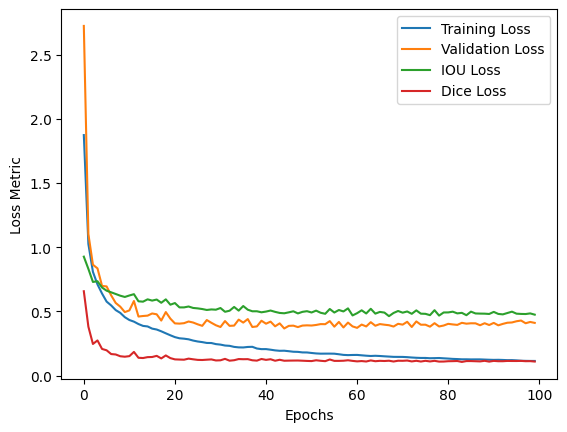

In [ ]:
plt.plot(range(NUM_EPOCHS), metrics['train_loss'], label='Training Loss')
plt.plot(range(NUM_EPOCHS), metrics['val_loss'], label='Validation Loss')
plt.plot(range(NUM_EPOCHS), metrics['iou_loss'], label='IOU Loss')
plt.plot(range(NUM_EPOCHS), metrics['dice_loss'], label='Dice Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Metric')
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'cityscape_segmentation_model.pt')

## Inference

In [ ]:
import random

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
images, labels = next(iter(val_loader))

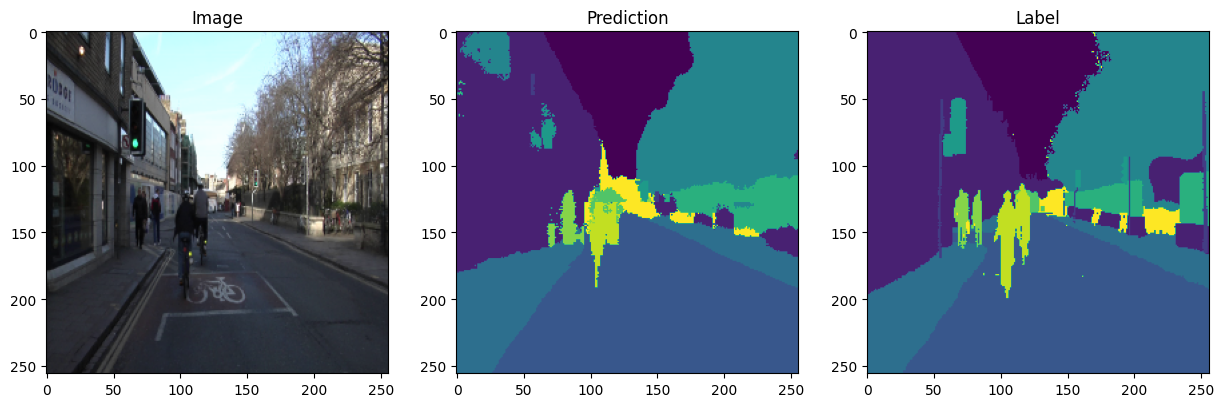

In [ ]:
idx = random.randint(0, BATCH_SIZE-1)
softmax = nn.Softmax(dim=0)
fig, ax = plt.subplots(1, 3, figsize=(15, 10))

with torch.no_grad():
  preds = model(images[idx].unsqueeze(0).to(DEVICE))

img = np.transpose(images[idx].numpy(), (1, 2, 0))
img = (img * std) + mean
ax[0].imshow(img)
ax[0].set_title('Image')

ax[1].imshow(torch.argmax(softmax(preds[0]), dim=0).cpu())
ax[1].set_title('Prediction')

ax[2].imshow(labels[idx])
ax[2].set_title('Label')

plt.show()